### Project Contributors: 18111006 (Alan Biju), 18111015 (Ayush Rai), 18111016 (Banoth Naveen Kumar), 18111025 (Gaurav Kar)

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')
sns.set_style('whitegrid')

import tensorflow as tf
from tensorflow.keras.models import Sequential
import tensorflow.keras.layers as Layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from PIL import Image

import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


### DATA UTILITIES

In [ ]:
df = pd.read_csv('/content/gdrive/My Drive/Chest-XRay-Dataset/Chest_xray_Corona_Metadata.csv')
df.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [ ]:
#show sum of nullvalues per feature
df.isnull().sum()

Unnamed: 0                   0
X_ray_image_name             0
Label                        0
Dataset_type                 0
Label_2_Virus_category    5841
Label_1_Virus_category    1576
dtype: int64

In [ ]:
#show datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5910 entries, 0 to 5909
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Unnamed: 0              5910 non-null   int64 
 1   X_ray_image_name        5910 non-null   object
 2   Label                   5910 non-null   object
 3   Dataset_type            5910 non-null   object
 4   Label_2_Virus_category  69 non-null     object
 5   Label_1_Virus_category  4334 non-null   object
dtypes: int64(1), object(5)
memory usage: 277.2+ KB


In [ ]:
#impute unknown to null data points.
df.fillna('unknown', inplace=True)
df.isnull().sum()

Unnamed: 0                0
X_ray_image_name          0
Label                     0
Dataset_type              0
Label_2_Virus_category    0
Label_1_Virus_category    0
dtype: int64

In [ ]:
print(df['Label_1_Virus_category'].value_counts())
print('='*50)
print(df['Label_2_Virus_category'].value_counts())

bacteria          2777
unknown           1576
Virus             1555
Stress-Smoking       2
Name: Label_1_Virus_category, dtype: int64
unknown          5841
COVID-19           58
Streptococcus       5
SARS                4
ARDS                2
Name: Label_2_Virus_category, dtype: int64


In [ ]:
#separate train data and test data
train_data = df[df['Dataset_type']=='TRAIN']
test_data = df[df['Dataset_type']=='TEST']
print('Train shape: ',train_data.shape)
print('Test Shape: ',test_data.shape)

Train shape:  (5286, 6)
Test Shape:  (624, 6)


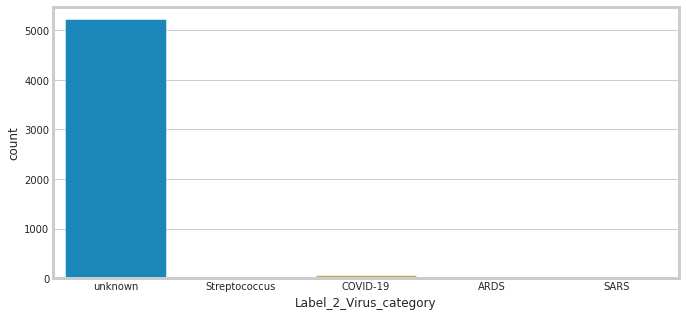

In [ ]:
#show a countplot
plt.figure(figsize=(10,5))
sns.countplot(train_data['Label_2_Virus_category']);

In [ ]:
#get the path of train and test folders
train_img_path = '/content/gdrive/My Drive/Chest-XRay-Dataset/Chest-XRay-Dataset/train'
test_img_path = '/content/gdrive/My Drive/Chest-XRay-Dataset/Chest-XRay-Dataset/test'

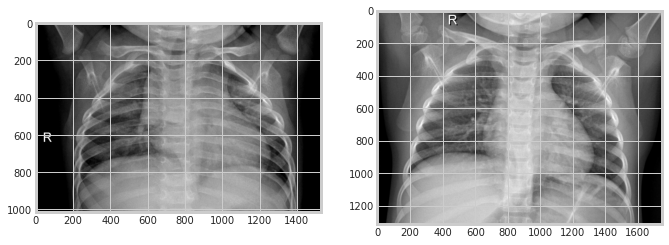

In [ ]:
#show sample image
samp_img1 = Image.open(os.path.join(train_img_path, train_data['X_ray_image_name'][0]))
samp_img2 = Image.open(os.path.join(train_img_path, train_data['X_ray_image_name'][22]))
fig, ax =plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(samp_img1, cmap='gray');
ax[1].imshow(samp_img2, cmap='gray');

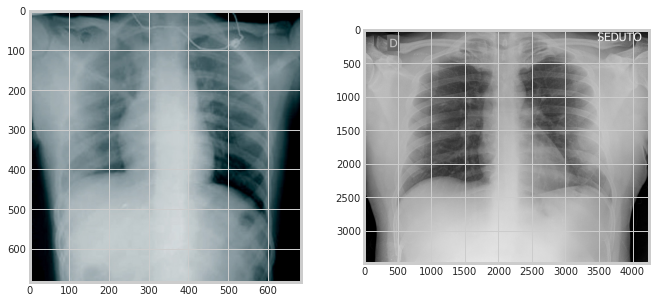

In [ ]:
#sample x-ray image of person with covid-19
with_covid = train_data[train_data['Label_2_Virus_category'] == 'COVID-19']

#show sample image
samp_img1 = Image.open(os.path.join(train_img_path, with_covid['X_ray_image_name'].iloc[8]))
samp_img2 = Image.open(os.path.join(train_img_path, with_covid['X_ray_image_name'].iloc[15]))
fig, ax =plt.subplots(1,2, figsize=(10,5))
ax[0].imshow(samp_img1);
ax[1].imshow(samp_img2);

In [ ]:
#remove Pnuemonia with unknown value
final_train_data = train_data[(train_data['Label'] == 'Normal') | 
                              ((train_data['Label'] == 'Pnemonia') &
                               (train_data['Label_2_Virus_category'] == 'COVID-19'))]

In [ ]:
# add a target and class feature
final_train_data['class'] = final_train_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')
test_data['class'] = test_data.Label.apply(lambda x: 'negative' if x=='Normal' else 'positive')

final_train_data['target'] = final_train_data.Label.apply(lambda x: 0 if x=='Normal' else 1)
test_data['target'] = test_data.Label.apply(lambda x: 0 if x=='Normal' else 1)

In [ ]:
#get the important features
final_train_data = final_train_data[['X_ray_image_name', 'class', 'target', 'Label_2_Virus_category']]
final_test_data = test_data[['X_ray_image_name', 'class', 'target']]

In [ ]:
test_data['Label'].value_counts()

Pnemonia    390
Normal      234
Name: Label, dtype: int64

### DATA AUGMENTATION

In [ ]:


#create a imagegenerator for for augmentation
datagen =  ImageDataGenerator(
  shear_range=0.2,
  zoom_range=0.2,
)

# function to convert image to array
def read_img(filename, size, path):
    img = image.load_img(os.path.join(path, filename), target_size=size)
    #convert image to array
    img = image.img_to_array(img) / 255
    return img

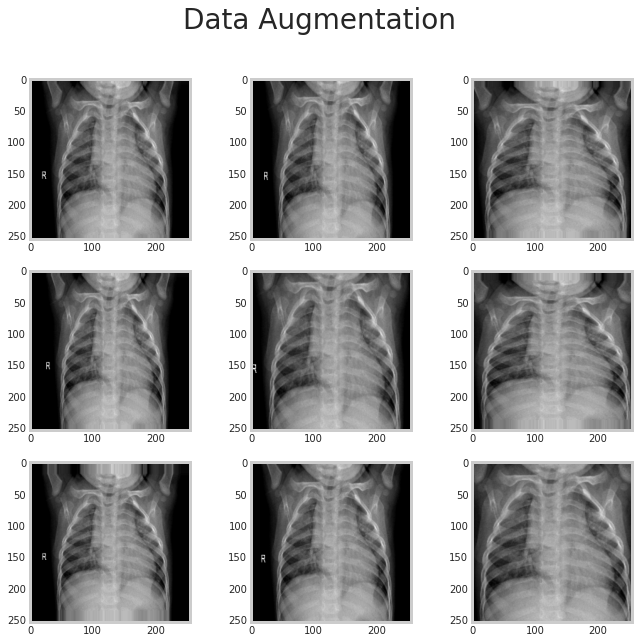

In [ ]:
#read a sample image
samp_img = read_img(final_train_data['X_ray_image_name'][0],
                                 (255,255),
                                 train_img_path)

plt.figure(figsize=(10,10))
plt.suptitle('Data Augmentation', fontsize=28)

i = 0

#show augmented images
for batch in datagen.flow(tf.expand_dims(samp_img,0), batch_size=6):
    plt.subplot(3, 3, i+1)
    plt.grid(False)
    plt.imshow(batch.reshape(255, 255, 3));
    
    if i == 8:
        break
    i += 1
    
plt.show();

In [ ]:
#augment the images labeled with covid-19 to balance the data

corona_df = final_train_data[final_train_data['Label_2_Virus_category'] == 'COVID-19']
with_corona_augmented = []

#create a function for augmentation
def augment(name):
    img = read_img(name, (255,255), train_img_path)
    i = 0
    for batch in tqdm(datagen.flow(tf.expand_dims(img, 0), batch_size=32)):
        with_corona_augmented.append(tf.squeeze(batch).numpy())
        if i == 20:
            break
        i =i+1

#apply the function
corona_df['X_ray_image_name'].apply(augment)

20it [00:00, 64.89it/s]
20it [00:00, 65.44it/s]
20it [00:00, 68.31it/s]
20it [00:00, 66.53it/s]
20it [00:00, 67.39it/s]
20it [00:00, 63.62it/s]
20it [00:00, 67.66it/s]
20it [00:00, 65.44it/s]
20it [00:00, 65.70it/s]
20it [00:00, 67.85it/s]
20it [00:00, 69.65it/s]
20it [00:00, 65.46it/s]
20it [00:00, 68.93it/s]
20it [00:00, 66.32it/s]
20it [00:00, 69.59it/s]
20it [00:00, 66.81it/s]
20it [00:00, 69.28it/s]
20it [00:00, 67.38it/s]
20it [00:00, 67.74it/s]
20it [00:00, 63.85it/s]
20it [00:00, 65.81it/s]
20it [00:00, 65.27it/s]
20it [00:00, 66.79it/s]
20it [00:00, 64.23it/s]
20it [00:00, 67.06it/s]
20it [00:00, 66.88it/s]
20it [00:00, 66.65it/s]
20it [00:00, 66.31it/s]
20it [00:00, 65.68it/s]
20it [00:00, 65.99it/s]
20it [00:00, 67.31it/s]
20it [00:00, 68.38it/s]
20it [00:00, 66.54it/s]
20it [00:00, 64.80it/s]
20it [00:00, 68.02it/s]
20it [00:00, 69.28it/s]
20it [00:00, 66.29it/s]
20it [00:00, 64.71it/s]
20it [00:00, 65.80it/s]
20it [00:00, 66.81it/s]
20it [00:00, 66.27it/s]
20it [00:00, 67.

5221    None
5222    None
5223    None
5224    None
5225    None
5226    None
5227    None
5228    None
5229    None
5230    None
5237    None
5238    None
5239    None
5240    None
5242    None
5243    None
5244    None
5245    None
5246    None
5247    None
5248    None
5249    None
5250    None
5251    None
5252    None
5253    None
5254    None
5255    None
5256    None
5257    None
5258    None
5259    None
5260    None
5261    None
5262    None
5263    None
5264    None
5265    None
5266    None
5267    None
5268    None
5269    None
5270    None
5271    None
5272    None
5273    None
5274    None
5275    None
5276    None
5277    None
5278    None
5279    None
5280    None
5281    None
5282    None
5283    None
5284    None
5285    None
Name: X_ray_image_name, dtype: object

In [ ]:
# extract the image from traing data and test data, then convert them as array
train_arrays = [] 
final_train_data['X_ray_image_name'].apply(lambda x: train_arrays.append(read_img(x, (255,255), train_img_path)))
test_arrays = []
final_test_data['X_ray_image_name'].apply(lambda x: test_arrays.append(read_img(x, (255,255), test_img_path)))

5286    None
5287    None
5288    None
5289    None
5290    None
        ... 
5905    None
5906    None
5907    None
5908    None
5909    None
Name: X_ray_image_name, Length: 624, dtype: object

In [ ]:
print(len(train_arrays))
print(len(test_arrays))

1400
624


In [ ]:
#concatenate the training data labels and the labels for augmented images
y_train = np.concatenate((np.int64(final_train_data['target'].values), np.ones(len(with_corona_augmented), dtype=np.int64)))

### CONVERT ALL THE DATA TO TENSORS

In [ ]:
train_tensors = tf.convert_to_tensor(np.concatenate((np.array(train_arrays), np.array(with_corona_augmented))))
test_tensors  = tf.convert_to_tensor(np.array(test_arrays))
y_train_tensor = tf.convert_to_tensor(y_train)
y_test_tensor = tf.convert_to_tensor(final_test_data['target'].values)

### CREATE A TENSOR DATASET

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_tensors, y_train_tensor))
test_dataset = tf.data.Dataset.from_tensor_slices((test_tensors, y_test_tensor))

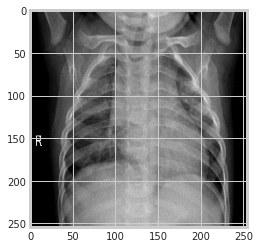

In [ ]:
for i,l in train_dataset.take(1):
    plt.imshow(i);

### GENERATE BATCHES

In [ ]:
BATCH_SIZE = 16
BUFFER = 1000

train_batches = train_dataset.shuffle(BUFFER).batch(BATCH_SIZE)
test_batches = test_dataset.batch(BATCH_SIZE)

for i,l in train_batches.take(1):
    print('Train Shape per Batch: ',i.shape);
for i,l in test_batches.take(1):
    print('Test Shape per Batch: ',i.shape);

Train Shape per Batch:  (16, 255, 255, 3)
Test Shape per Batch:  (16, 255, 255, 3)


### TRANSFER LEARNING RESNET

In [ ]:
#define input shape
INPUT_SHAPE = (255,255,3) 

#get the pretrained model
base_model = tf.keras.applications.ResNet50(input_shape= INPUT_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

#set the trainable method of covolution layer as false
# why set to false?? because we don't want to mess up the pretrained weights of the model!!
base_model.trainable = False
base_model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 255, 255, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 261, 261, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 128, 128, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1_conv[0][0]                 
__________________________

In [ ]:
#let's try to pass an image to the model to verify the output shape
for i,l in train_batches.take(1):
    pass
base_model(i).shape

TensorShape([16, 8, 8, 2048])

### OKAY, LET'S ADD A DENSE LAYER FOR IMAGE CLASSIFICATION

In [ ]:
model = Sequential()
model.add(base_model)
model.add(Layers.GlobalAveragePooling2D())
model.add(Layers.Dense(128))
model.add(Layers.Dropout(0.2))
model.add(Layers.Dense(1, activation = 'sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 8, 8, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               262272    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 129       
Total params: 23,850,113
Trainable params: 262,401
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
#add a earlystopping callback to stop the training if the model is not learning anymore
callbacks = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)

#let's just choose adam as our optimizer.
model.compile(optimizer='adam',
              loss = 'binary_crossentropy',
              metrics=['accuracy'])

### Final Result

In [ ]:
model.fit(train_batches, epochs=10, validation_data=test_batches, callbacks=[callbacks])

Epoch 1/10
164/164 [==============================] - 631s 4s/step - loss: 0.5233 - accuracy: 0.7983 - val_loss: 0.8388 - val_accuracy: 0.4744
Epoch 2/10
164/164 [==============================] - 627s 4s/step - loss: 0.2780 - accuracy: 0.9053 - val_loss: 0.6083 - val_accuracy: 0.7308
Epoch 3/10
164/164 [==============================] - 629s 4s/step - loss: 0.1848 - accuracy: 0.9408 - val_loss: 0.7438 - val_accuracy: 0.6859
Epoch 4/10
164/164 [==============================] - 634s 4s/step - loss: 0.1303 - accuracy: 0.9633 - val_loss: 0.6660 - val_accuracy: 0.7436


In [ ]:
#predict the test data
pred = (model.predict((np.array(test_arrays))) > 0.5).astype("int32")

In [ ]:
#let's print a classification report
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(test_data['target'], pred.flatten()))

              precision    recall  f1-score   support

           0       0.63      0.77      0.69       234
           1       0.84      0.73      0.78       390

    accuracy                           0.74       624
   macro avg       0.74      0.75      0.74       624
weighted avg       0.76      0.74      0.75       624



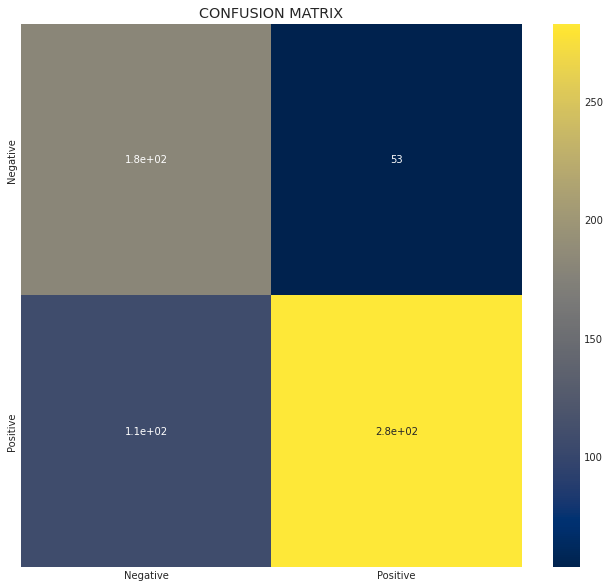

In [ ]:
### Confusion Matrix

con_mat = confusion_matrix(test_data['target'], pred.flatten())
plt.figure(figsize = (10,10))
plt.title('CONFUSION MATRIX')
sns.heatmap(con_mat, cmap='cividis',
            yticklabels=['Negative', 'Positive'],
            xticklabels=['Negative', 'Positive'],
            annot=True);

### WRAP UP!